# BBC News Classification

## Project Overview

In this project I will use sklearn's TF-IDF method to vectorize the text data provided in the BBC News Classification dataset.
I will then use Truncated SVD to perform matrix factorization and predict topic labels to articles in the train set. Then I will tune the hyperparameters of my TF-IDF / SVD method to produce an optimized unsupervised learning method. The test accuracy can be evaluated by Kaggle.

I will then train and develop a supervised learning classifier by comparing LinearSVC and Logistic Regression's performance on training data. The better method will then be compared against the tuned unsupervised model to evaluate overall performance on test and train data.


## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from collections import Counter
from itertools import product
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [2]:
# Import data
train_df = pd.read_csv('BBC News Train.csv')
test_df = pd.read_csv('BBC News Test.csv')

# Inspect basic data features (shape of data, number of features, type of features, etc)
print('Inspecting basic info for each dataset....')
print('TRAINING SET:')
print(train_df.info())
print(train_df.describe(include=['object']))
print('TEST SET:')
print(test_df.info())
print(test_df.describe(include=['object']))

print(f'Total unique labels in train_df: {train_df['Category'].nunique()}')

print(type(train_df))

Inspecting basic info for each dataset....
TRAINING SET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None
                                                     Text Category
count                                                1490     1490
unique                                               1440        5
top     microsoft seeking spyware trojan microsoft is ...    sport
freq                                                    2      346
TEST SET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 

There are no null values in any column in either the test_df or train_df. Each dataset contains these two features:

* **ArticleId** - Unique identifier for each article
* **Text** - Words included in article

The training set also contains the label **Category** which specifies the type of article. There are 5 unique choices for Category.

## Data Cleaning

**Dropping Duplicates**

There appear to be duplicates in train_df. For instances where the label and text field both match, these are true duplicate articles and can be dropped.

**Removing Numbers from Strings**

I removed any strings that contained number values (0-9) and replaced with the string "#NUMBER". This was to balance the need to reduce noise from numbers in the Text field while also preserving the fact that numbers were mentioned at all in an article as part of the attribute of that article (Python | Remove all digits from a list of strings, 2025).

In [248]:
# Drop duplicates from train_df and reset index
train_df.drop_duplicates(subset=['Text', 'Category']).reset_index(drop=True, inplace=True)

# Replace any text string with a number and replace with str '#NUMBER'
train_df['Text'] = [re.sub(r'\d+', '#NUMBER', w) for w in train_df['Text']]
test_df['Text'] = [re.sub(r'\d+', '#NUMBER', w) for w in test_df['Text']]

print(f'TRAIN DATA: {train_df.describe(include=['object'])}')
print(f'TEST DATA: {test_df.describe(include=['object'])}')

TRAIN DATA:                                                      Text Category
count                                                1490     1490
unique                                               1440        5
top     microsoft seeking spyware trojan microsoft is ...    sport
freq                                                    2      346
TEST DATA:                                                      Text
count                                                 735
unique                                                722
top     boothroyd calls for lords speaker betty boothr...
freq                                                    2


## Data Inspection

**Vizualizing Data by Category**

I want to look at the frequency of labels in the train set, as well as the length of article by category based on total word count in each Text value.

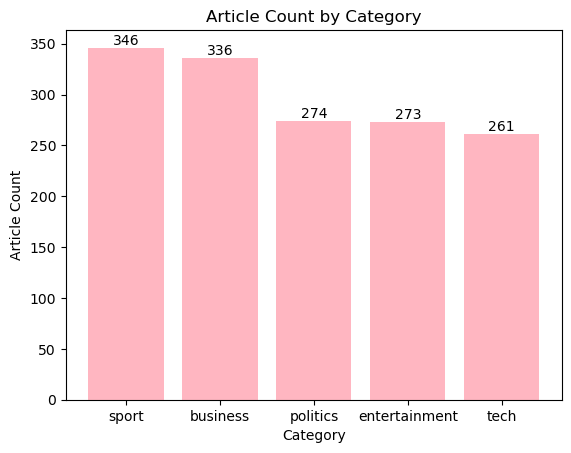

In [249]:
# Get count of articles by Category
#category_count = pd.DataFrame(data=train_df.groupby('Category')['Text'].count(), columns=['CategoryName', 'ArticleCount'])
category_count = train_df.groupby('Category')['Text'].count().reset_index().sort_values(by='Text', ascending=False)

# Bar chart of categories and frequency
fig, ax = plt.subplots()
bars = ax.bar(category_count['Category'], category_count['Text'], color='lightpink')
ax.set_xlabel('Category')
ax.set_ylabel('Article Count')
ax.set_title('Article Count by Category')
ax.bar_label(bars, fmt='%d')
plt.show()

        Category        mean  median  min   max
4           tech  501.858238   457.0  188  1549
2       politics  449.689781   441.5   90  3345
3          sport  335.346821   294.5  116  1671
0       business  334.169643   304.0  145   902
1  entertainment  333.912088   272.0  144  2448


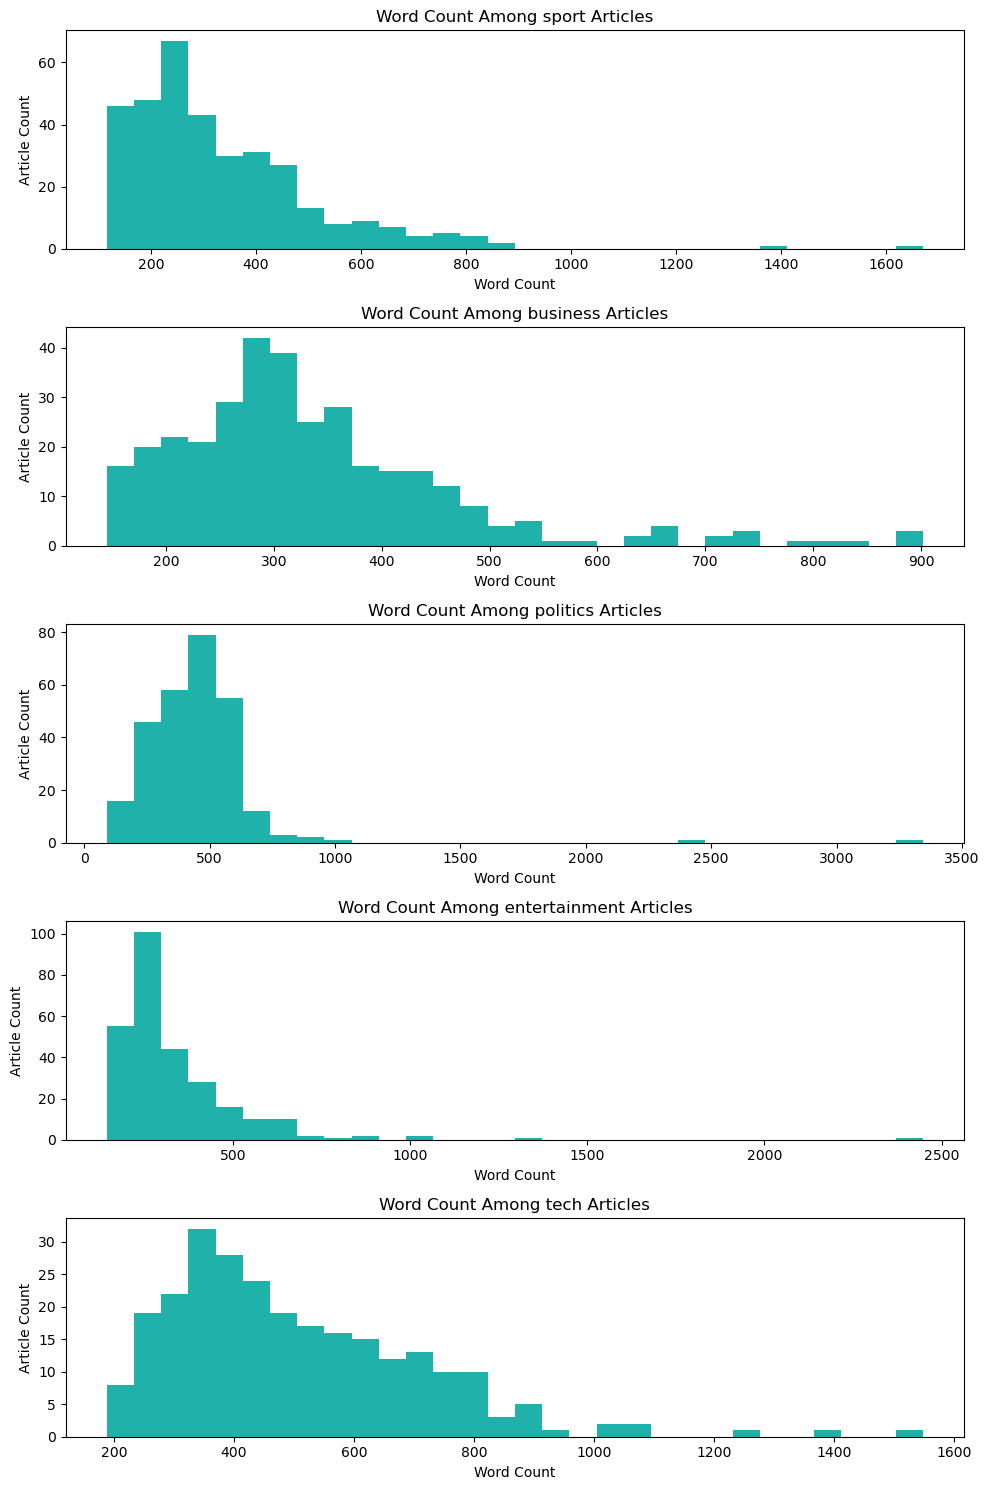

In [276]:
# Split and get count of words in each Text field for all articles
train_df['word_count'] = train_df['Text'].apply(lambda x: len(x.split()))
word_count_by_category = train_df.groupby('Category')['word_count'].agg(['mean', 'median', 'min', 'max']).reset_index().sort_values(by='mean', ascending=False)

# Get median and avg word count across Categories
print(word_count_by_category)

# Prep category data for histograms
cats = train_df['Category'].value_counts().index
subsets = {cat: train_df['Category'] == cat for cat in cats}

# Histograms of word count by category
fig, axes = plt.subplots(5, 1, figsize=(10,15))
for ax, (cat, mask) in zip(axes, subsets.items()):
    hist_data = train_df.loc[mask, 'word_count']
    ax.hist(hist_data, bins=30, color='lightseagreen')
    ax.set_title(f'Word Count Among {cat} Articles')
    ax.set_xlabel('Word Count')
    ax.set_ylabel('Article Count')
    
plt.tight_layout()
plt.show()


The labels appear to be well-balanced, with the top Category being "sport" with 346 articles. This makes things slightly easier in model training and evaluation steps, since we don't need to rebalance the data with artificial sample generation (or another method for dealing with imbalanced labels).

There is some variation among Categories for total word count across articles, with **tech** having the highest mean and median word count and **politics** having the widest spread of data.

There are mixes of uppercase and lowercase, as well as whitespace and punctuation that I will need to consider during pre-processing steps.


## Pre-processing - Vectorize Data with TF-IDF

TF-IDF is useful for vectorizing words in text documents by considering the frequency of each word in a given document. In basic terms, each word in a document is assigned a numerical weight based on its frequency within a given document and its inverse frequency across other documents. A word that appears very frequently in a given document but very rarely across other documents is given a larger weight in that document, and words that occur most frequently everywhere ("the", "and", "with", etc) are penalized. I also chose TF-IDF for its ability to programmatically remove the most common English words, **remove whitespace & punctuation**, and **convert text to lowercase** for pre-processing.

The output for X is the word location (article_index, word_index) and the vector.

The actual features (words) are given by X.get_feature_names_out().

I will fit the vectorizer **on training data only** so that the test data remains truly **unseen** by the model, which allows us to preserve the test data for proper scoring later. Both the test and train sets will be transformed by the TF-IDF vectorizer that I will train on the training data.

(Source: Understanding TF-IDF (Term Frequency-Inverse Document Frequency))

**Visualize Top Words**

To check my understanding of the data after vectorizing, I will look at the top words across all Categories.

tfidf_matrix_train.shape: (1490, 23272)
tfidf_matrix_train type: <class 'scipy.sparse._csr.csr_matrix'>
Sample of vectors in tfidf_matrix:   (0, 23005)	0.49590784150953837
  (0, 7205)	0.08323128344986644
  (0, 2427)	0.03653455421920377
  (0, 11762)	0.05438975425478096
  (0, 5350)	0.04058654701120617
  (0, 11791)	0.1476531350210449
  (0, 5358)	0.04921771167368163
  (0, 3547)	0.08259363281460484
  (0, 2002)	0.058629443761865206
  (0, 6547)	0.34571062237306627
  (0, 1778)	0.0551008712788376
  (0, 8248)	0.17274311488970917
  (0, 3448)	0.1217596410336185
  (0, 2974)	0.02863538039499117
  (0, 4106)	0.05315758253530729
  (0, 22766)	0.07306210210161564
  (0, 22913)	0.11340774051146513
  (0, 5058)	0.06917138518335218
  (0, 4579)	0.22347574470762058
  (0, 9453)	0.034696613181549554
  (0, 10705)	0.05310842859194509
  (0, 150)	0.3503685202675634
  (0, 564)	0.06426966156540123
  (0, 5846)	0.04773852975155744
  (0, 10872)	0.06641087759839212
  :	:
  (0, 9713)	0.02868230317116528
  (0, 2382)	0.047076

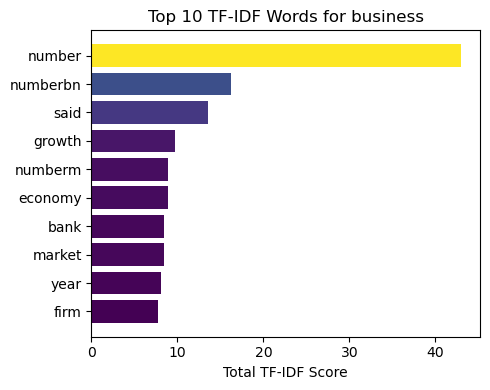

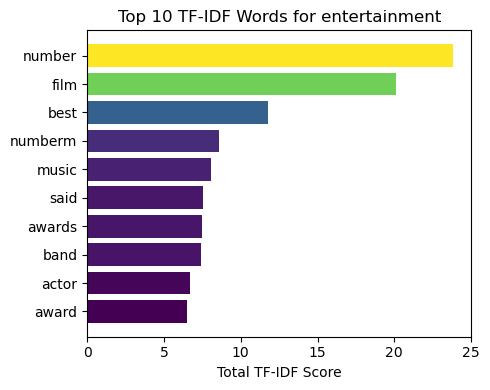

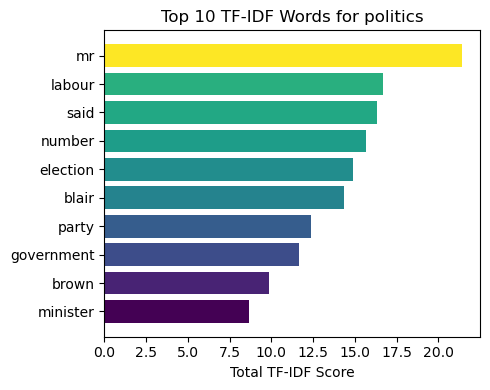

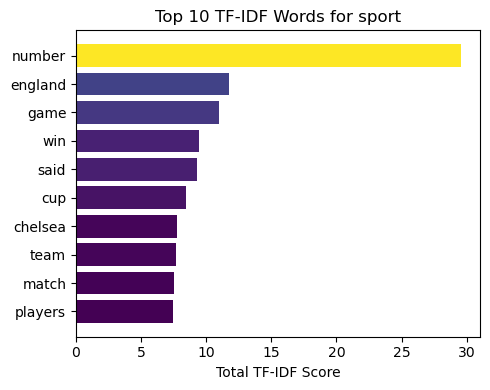

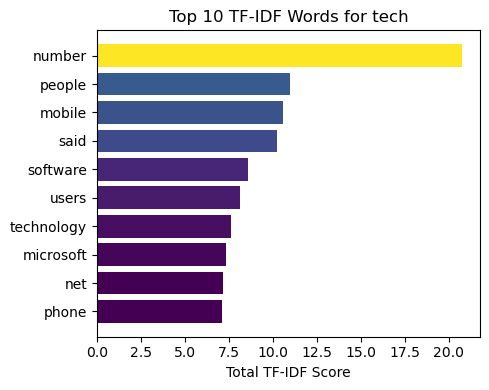

In [278]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
vectorize = TfidfVectorizer(lowercase=True, analyzer='word', stop_words='english')

# Fit_transform training set
tfidf_matrix_train = vectorize.fit_transform(train_df['Text'])
feature_names = vectorize.get_feature_names_out()

# Transform test set using fitted vectorizer
tfidf_matrix_test = vectorize.transform(test_df)

# Inspect vectorized word object
print(f'tfidf_matrix_train.shape: {tfidf_matrix_train.shape}')
print(f'tfidf_matrix_train type: {type(tfidf_matrix_train)}')
print(f'Sample of vectors in tfidf_matrix: {tfidf_matrix_train[:1]}')
print(f'Feature names: {feature_names}')
print(f'Count of features: {len(feature_names)}')

# Create df of tfidf results w/labels attached
tfidf_df = pd.DataFrame(tfidf_matrix_train.toarray(), columns=feature_names)
#.sum(axis=0).sort_values(ascending=False)
tfidf_df['Category'] = train_df['Category'].values

# Get sum of vectors per category
category_tfidf = tfidf_df.groupby('Category').sum()

# Function to find and plot top n words within given category
def plot_top_words(category, n):
    row = category_tfidf.loc[category]
    top_words = row.nlargest(n)

    # Set colormap for bar charts
    norm = plt.Normalize(min(top_words.values[::-1]), max(top_words.values[::-1]))
    cmap = plt.cm.viridis
    colors = [cmap(norm(val)) for val in top_words.values[::-1]]

    # Create horizontal bar charts for chosen category
    plt.figure(figsize=(5, 4))
    plt.barh(top_words.index[::-1], top_words.values[::-1], color=colors)
    plt.title(f"Top {n} TF-IDF Words for {category}")
    plt.xlabel("Total TF-IDF Score")
    plt.tight_layout()
    plt.show()

for category in category_tfidf.index:
    plot_top_words(category, n=10)


## Dimensionality Reduction with Truncated SVD

**Next steps:**
* Perform matrix factorization using Truncated SVD
* Identify subgroups (topics) within the data
* Train an unsupervised KMeans clustering model to group together articles by topic
* Check accuracy of my unsupervised model on the task of classifyinf topics within the BBC News article dataset
* Perform hyperparameter tuning to improve accuracy
* Train a supervised model and compare supervised performance against unsupervised performance

Truncated SVD decomposes the matrix of articles and their component text fields, then reports the top k most important subgroups within the matrix (and their associated vectors). Similarities are found by identifying words that commonly appear together (co-occurences).
Beginning with an m x n matrix of articles and text, SVD identifies a decomposed m x d matrix of articles and topics, a d x d diagonal matrix of topic weights, and a n x d matrix of text and topics.
From these k latent features, we can discover underlying structure in the data. Because we've been given the fact that 5 topics are possible, we can use n_components=5 in the implementation initially.

SVD is also useful here because this dataset has no null values, so no imputation is needed before implementing.

For unsupervised learning, the **test data should NOT be included in model training**, since we later want to evaluate how well the model does on **unseen** data, and the test_df should be reserved for that purpose to prevent data leakage.


In [279]:
# Implement SVD
svd_basic = TruncatedSVD(n_components=5, random_state=42)

# Fit and transform test and train sets
tfidf_svd_train = svd_basic.fit_transform(tfidf_matrix_train)
tfidf_svd_test = svd_basic.transform(tfidf_matrix_test)

Training accuracy: 0.936
Classification Report for Basic SVD:
               precision    recall  f1-score   support

     business       0.92      0.90      0.91       336
entertainment       0.92      0.95      0.94       273
     politics       0.89      0.90      0.90       274
        sport       0.99      0.99      0.99       346
         tech       0.95      0.93      0.94       261

     accuracy                           0.94      1490
    macro avg       0.93      0.93      0.93      1490
 weighted avg       0.94      0.94      0.94      1490



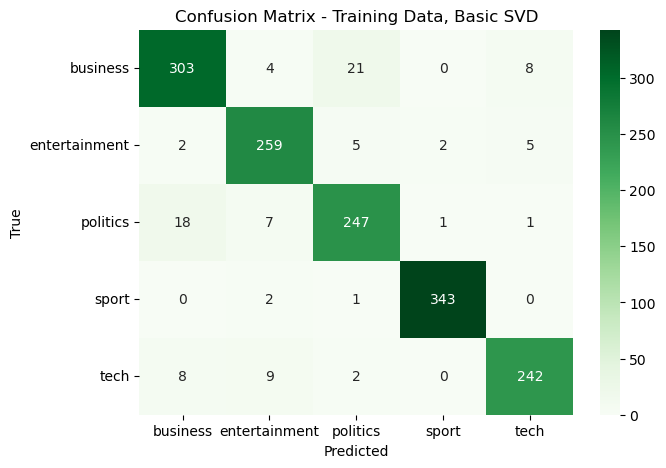

In [280]:
# Function to use similarity matrix and label inputs to actually predict a label for train and test data
# Relies on COSINE SIMILARITY
def svd_predict(tfidf_train, tfidf_test, train_labels, n_components):
    # Fit SVD using input param for n_components
    svd_model = TruncatedSVD(n_components=n_components, random_state=42)
    X_train_svd = svd_model.fit_transform(tfidf_train)
    X_test_svd = svd_model.transform(tfidf_test)

    # Calc cosine similarity for training data
    train_simmat = cosine_similarity(X_train_svd, X_train_svd)

    # Run predictions on train set, excluding self-similarity in simmat
    train_preds = []
    for i, sim in enumerate(train_simmat):
        sim_copy = sim.copy()
        sim_copy[i] = -np.inf
        # Location of most similar idx
        most_sim_idx = np.argmax(sim_copy)
        # Label value of most similar idx
        train_preds.append(train_labels[most_sim_idx])

    # Get test set cosine similarity against train_svd
    test_simmat = cosine_similarity(X_test_svd, X_train_svd)
    test_preds = []
    for sim in test_simmat:
        most_sim_idx = np.argmax(sim)
        test_preds.append(train_labels[most_sim_idx])

    return train_preds, test_preds, svd_model

# Identify training labels to function as "y_true" for train accuracy
train_labels = train_df['Category'].values

# Use function to generate preds for "basic SVD" approach
train_preds, test_preds, svd_model = svd_predict(
    tfidf_train=tfidf_matrix_train,
    tfidf_test=tfidf_matrix_test,
    train_labels=train_labels,
    n_components=5
)

# Get train accuracy
train_acc = accuracy_score(train_labels, train_preds)
print(f"Training accuracy: {train_acc:.3f}")

# Get classification report
print('Classification Report for Basic SVD:')
print(classification_report(train_labels, train_preds))

# Confusion matrix for training data
cm = confusion_matrix(train_labels, train_preds, labels=np.unique(train_labels))
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(train_labels), yticklabels=np.unique(train_labels), cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Training Data, Basic SVD")
plt.show()

After using a basic Truncated SVD with an initial n_components=5 and identifying a label for each article in the training set using **cosine similarity** we achieve a training accuracy of 0.936. The F1 scores are also returning solid results across each category, showing a good balance between precision and recall.

## Hyperparameter Tuning on TF-IDF
The results of TF_IDF vectorization have a large impact on model performance. I will proceed with tuning some of the hyperparameters of TF-IDF to try and identify an optimized version to pass into SVD.
Then I will pass this model to Kaggle to return a test accuracy.

The hyperparameters I'm targeting in this step are:
* max_features
* ngram_range

The greater the max number of features, the larger the possible similarity matrix. If we limit the max number of features to k, then only the k most frequent words across our document set will be considered as features (Source: Scikit-Learn Vectorizer max_features).

The ngram_range controls the collections of commonly grouped words in the text that can be considered by the model. For example, "peanut" is a unigram with ngram=1 but "peanut butter" is a bigram with ngram=2. Testing the allowed boundaries of the ngram_range will allow us to get more insight into the best allowable co-occurrences of words.

In [281]:
# HYPERPARAM TUNING
def run_tuning(text_data, labels, max_features, ngram_range, n_components=5):
    # Create new vectorizer using input params
    vec = TfidfVectorizer(stop_words="english", lowercase=True, analyzer='word',
                          max_features=max_features, ngram_range=ngram_range)
    # Fit_transform text_data using vec
    X_vec = vec.fit_transform(text_data)
    
    # Apply SVD to X_vec
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_svd = svd.fit_transform(X_vec)

    # Create simmat on train vs train data
    simmat = cosine_similarity(X_svd, X_svd)

    # Predict using closest neighbor in cosine sim matrix
    preds = []
    for i, sim in enumerate(simmat):
        # Take copy or else all results have the same acc
        #simcopy = sim.copy()
        sim[i] = -np.inf
        most_sim_idx = np.argmax(sim)
        preds.append(labels[most_sim_idx])

    # Calc accuracy from training labels and return as result
    acc = accuracy_score(labels, preds)

    return acc
    

# Create grid of hyperparams to tune
# Choosing reasonable max_features values based on size of dataset and number of unique words
max_features_list = [500, 1000, 5000, 10000, 20000]
# Choosing combinations of unigram and bigram values allowable by model
ngram_range_list = [(1,1), (1, 2), (2,2)]

# Run tuning process
tuning_results = []
# Walk through each combination and apply run_tuning() method
for max_feat, ngram in product(max_features_list, ngram_range_list):
    print(f'Testing: max_features={max_feat}, ngram_range={ngram}')
    acc = run_tuning(
        text_data=train_df['Text'],
        labels=train_df['Category'].values,
        max_features=max_feat,
        ngram_range=ngram,
        n_components=5
    )
    # Store results in tuning_results array
    tuning_results.append({
        "max_features": max_feat,
        "ngram_range": ngram,
        "train_accuracy": acc
    })
# Store results in df and sort by accuracy desc
results_df = pd.DataFrame(tuning_results).sort_values(by='train_accuracy', ascending=False)
print(results_df)

Testing: max_features=500, ngram_range=(1, 1)
Testing: max_features=500, ngram_range=(1, 2)
Testing: max_features=500, ngram_range=(2, 2)
Testing: max_features=1000, ngram_range=(1, 1)
Testing: max_features=1000, ngram_range=(1, 2)
Testing: max_features=1000, ngram_range=(2, 2)
Testing: max_features=5000, ngram_range=(1, 1)
Testing: max_features=5000, ngram_range=(1, 2)
Testing: max_features=5000, ngram_range=(2, 2)
Testing: max_features=10000, ngram_range=(1, 1)
Testing: max_features=10000, ngram_range=(1, 2)
Testing: max_features=10000, ngram_range=(2, 2)
Testing: max_features=20000, ngram_range=(1, 1)
Testing: max_features=20000, ngram_range=(1, 2)
Testing: max_features=20000, ngram_range=(2, 2)
    max_features ngram_range  train_accuracy
9          10000      (1, 1)        0.934899
12         20000      (1, 1)        0.934899
6           5000      (1, 1)        0.934228
7           5000      (1, 2)        0.930872
10         10000      (1, 2)        0.930872
13         20000      

Training accuracy for SVD after Optimized TF-IDF: 0.934
Classification Report for Tuned SVD:
               precision    recall  f1-score   support

     business       0.91      0.90      0.90       336
entertainment       0.93      0.95      0.94       273
     politics       0.90      0.90      0.90       274
        sport       0.99      0.99      0.99       346
         tech       0.94      0.92      0.93       261

     accuracy                           0.93      1490
    macro avg       0.93      0.93      0.93      1490
 weighted avg       0.93      0.93      0.93      1490



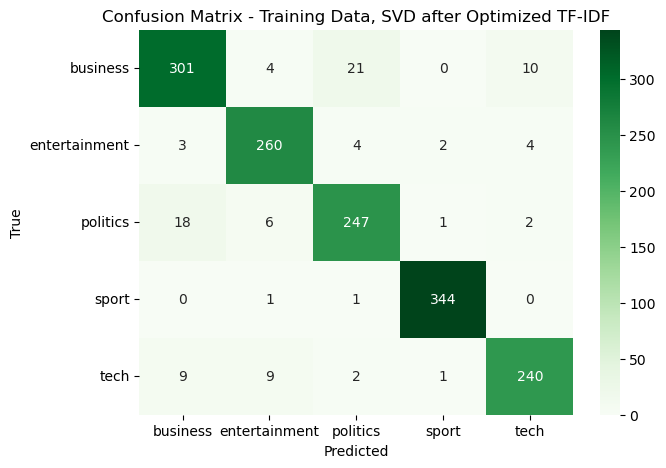

In [282]:
# Apply TF-IDF and SVD to test set using tuned hyperparameters from previous step
vec = TfidfVectorizer(stop_words="english", lowercase=True, analyzer='word',
                          max_features=5000, ngram_range=(1,1))
# Fit_transform text_data using vec
X_train_opt = vec.fit_transform(train_df['Text'])
# Transform test data using vectorizer
X_test_opt = vec.transform(test_df['Text'])

# Generate results from optimized model
# Apply TF-IDF and SVD to test set using tuned hyperparameters from previous step
vec = TfidfVectorizer(stop_words="english", lowercase=True, analyzer='word',
                          max_features=5000, ngram_range=(1,1))
# Fit_transform text_data using vec
X_train_opt = vec.fit_transform(train_df['Text'])
# Transform test data using vectorizer
X_test_opt = vec.transform(test_df['Text'])

opt_train_preds, opt_test_preds, opt_svd_model = svd_predict(
    tfidf_train=X_train_opt,
    tfidf_test=X_test_opt,
    train_labels=train_labels,
    n_components=5
)

# Get train accuracy
opt_train_acc = accuracy_score(train_labels, opt_train_preds)
print(f'Training accuracy for SVD after Optimized TF-IDF: {opt_train_acc:.3f}')

# Get classification report
print('Classification Report for Tuned SVD:')
print(classification_report(train_labels, opt_train_preds))

# Confusion matrix for training data
cm = confusion_matrix(train_labels, opt_train_preds, labels=np.unique(train_labels))
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(train_labels), yticklabels=np.unique(train_labels), cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Training Data, SVD after Optimized TF-IDF")
plt.show()

# Need to use Kaggle submission to get test accuracy from hidden labels
submission = pd.DataFrame({'ArticleId': test_df['ArticleId'], 'Category': opt_test_preds})
# Save submission file to CSV
submission.to_csv("svd_opt_submission.csv", index=False)

## Results of Hyperparameter Tuning SVD

The highest **training accuracy of 0.946** is achieved when the TF-IDF vectorization step includes max_features=5000 and ngram_range=(1,1). This seems reasonable, based on the total number of words in the this training set and the types of text data involved.

I ran a full evaluation with a confusion matrix and classification report for the new training data performance. The F1 scores are higher and the confusion matrix shows greater predictive power than the basic SVD method before hyperparameter tuning.

I also generated label predictions for the test set and pass the test results of the optimized model to Kaggle to calculate the test accuracy. Kaggle reports my **test accuracy** using the optimized SVD method as **0.936**.

Overall, the unsupervised methods appear to return excellent accuracy and F1 scores with the tuned hyperparameters of TF-IDF and n_components=5 for Truncated SVD. In a case where I did not know there were 5 topics in this dataset to begin with, I would have included n_components in the parameter grid to find an optimal value.

## Supervised Learning with Linear SVM and Logisitic Regression

This is a classification task! I will train a LinearSVM Classifier supervised learing model and a Logistic Regression Classifier using sklearn's libraries. These models are useful for classification tasks, and because the dataset is not too large the performance should be manageable for each of these methods.

I'll first split the TF-IDF vectorized training set into labeled test/train splits to better evaluate the supervised performance.

Then I'll use the results of the better supervised learning method to get test accuracy from Kaggle and finally compare results of all methods.

In [283]:
# Use datasets after applying TF-IDF with optimal hyperparameters determined in previous steps

# Split train_df into test/train splits
x_train, x_test, y_train, y_test = train_test_split(X_train_opt, train_labels, test_size=0.25, random_state=42)

# Train and fit basic LinearSVC
svc_clf = LinearSVC().fit(x_train, y_train)
# Train and fit basic LogisticRegression
lr_clf = LogisticRegression().fit(x_train, y_train)

# Generate predictions on TEST subsets for each model
y_pred_svc = svc_clf.predict(x_test)
y_pred_lr = lr_clf.predict(x_test)
# Generate predictions on TRAIN subsets for each model
y_pred_svc_tr = svc_clf.predict(x_train)
y_pred_lr_tr = lr_clf.predict(x_train)

# Calculate TEST accuracy on predictions
svc_acc = accuracy_score(y_test, y_pred_svc)
lr_acc = accuracy_score(y_test, y_pred_lr)
# Calculate TRAIN accuracy on predictions
svc_acc_tr = accuracy_score(y_train, y_pred_svc_tr)
lr_acc_tr = accuracy_score(y_train, y_pred_lr_tr)

# Get classification reports for each method on TRAIN performance
svc_clfrep = classification_report(y_test, y_pred_svc)
lr_clfrep = classification_report(y_test, y_pred_lr)

print(f'LinearSVC train accuracy: {svc_acc_tr:0.05f}')
print(f'LinearSVC test accuracy: {svc_acc:0.05f}')
print('LinearSVC classification report:')
print(svc_clfrep)

print(f'LogReg train accuracy: {lr_acc_tr:0.5f}')
print(f'LogReg test accuracy: {lr_acc:0.5f}')
print('LogReg classification report:')
print(lr_clfrep)

# Get Kaggle results for LinearSVC method
svc_test_predictions = svc_clf.predict(X_test_opt)
supervised_submission = pd.DataFrame({'ArticleId': test_df['ArticleId'], 'Category': svc_test_predictions})
# Save submission file to CSV
supervised_submission.to_csv("svc_test_submission.csv", index=False)

LinearSVC train accuracy: 1.00000
LinearSVC test accuracy: 0.97587
LinearSVC classification report:
               precision    recall  f1-score   support

     business       0.97      0.96      0.96        92
entertainment       0.97      1.00      0.98        63
     politics       0.97      0.96      0.96        71
        sport       1.00      1.00      1.00        81
         tech       0.97      0.97      0.97        66

     accuracy                           0.98       373
    macro avg       0.98      0.98      0.98       373
 weighted avg       0.98      0.98      0.98       373

LogReg train accuracy: 0.99642
LogReg test accuracy: 0.97051
LogReg classification report:
               precision    recall  f1-score   support

     business       0.94      0.97      0.95        92
entertainment       0.98      0.98      0.98        63
     politics       0.97      0.96      0.96        71
        sport       1.00      1.00      1.00        81
         tech       0.97      0.94 

## Comparing Model Results

Both methods work very well without hyperparameter tuning. LinearSVC does slightly better with a training accuracy of 0.976 and consistently high F1 scores across all labels. When I use my trained LinearSVC model to predict labels for the test dataset, Kaggle returns a **test accuracy score of 0.989**.

Below is a table comparing the results of my best **unsupervised learning** model with my best **supervised learning** model.
The LinearSVC supervised model outperforms the SVD w/TF-IDF unsupervised method.

In [284]:
svd_train_acc = 0.934
svd_test_acc  = 0.936

svc_train_acc = 0.976
svc_test_acc  = 0.989

# Create a 2x2 table
results_table = pd.DataFrame({
    "Train Accuracy": [svd_train_acc, svc_train_acc],
    "Test Accuracy":  [svd_test_acc, svc_test_acc],
},
index=["SVD Model", "LinearSVC"])

print(results_table)

           Train Accuracy  Test Accuracy
SVD Model           0.934          0.936
LinearSVC           0.976          0.989


## Discussion & Conclusion

It seems reasonable that the supervised learning method would outperform the unsupervised, since it is able to consider labels during training. In the absense of these labels, the unsupervised SVD method still has over 93% test and train accuracy, so it is still a powerful tool for uncovering underlying structure and latent features within text data like this. I suspect that the nature of news articles within the given topics are somewhat naturally separable, so the unsupervised model was able to identify more well-separated latent groupings within feature space.

The supervised model had a very high test accuracy and train accuracy from the training set without any hyperparameter tuning, which initially made me worry that overfitting was occurring. However, because the classifier still generalized so well to the actual (previously unlabeled) test data I do not suspect there is risk of overfitting even with the basic model.

Below, I will run an experiment on the supervised training data to test different thresholds for data labels. That is, I will withold different amounts of available labels and observe changes to test/train performance.
Because of the nature of unsupervised models, which **do not use labels** to begin with, the test and train accuracy **will not change for the SVD w/TF-IDF method**.

In [285]:
# Create function to test variations of train sizes
def evaluate_train_size_effects(x, y, train_sizes, random_state=42):
    results = []
    # Split data into test/train sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    
    # Walk through range of fractions
    for frac in train_sizes:
        n = int(X_train_full.shape[0] * frac)

        # Get subset of sample w/size frac (without replacement)
        idx = np.random.choice(X_train_full.shape[0], size=n, replace=False)
        X_sub = X_train_full[idx]
        y_sub = y_train_full[idx]

        # Train supervised model
        model = LinearSVC()
        model.fit(X_sub, y_sub)

        # Get train accuracy on the subset itself
        train_preds = model.predict(X_sub)
        train_acc = accuracy_score(y_sub, train_preds)

        # Test accuracy
        test_preds = model.predict(X_test)
        test_acc = accuracy_score(y_test, test_preds)

        results.append({
            "train_fraction": frac,
            "num_samples": n,
            "train_accuracy": train_acc,
            "test_accuracy": test_acc
        })

        print(f'Fraction {frac:.2f} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}')

    return pd.DataFrame(results)

# Using likely range of fractions
train_sizes = [0.10, 0.20, 0.50, 1.00]
# Run evaluation method
results_df = evaluate_train_size_effects(
    X_train_opt,
    train_labels,
    train_sizes
)

print('Results:')
print(results_df)

# Pull actual predictions on test set using LinearSVC trained on only 20% of labels
X_train_full, X_test, y_train_full, y_test = train_test_split(X_train_opt, train_labels, test_size=0.25, random_state=42)
n = int(X_train_full.shape[0] * 0.20)
# Get subset of sample w/20% of labels (without replacement)
idx = np.random.choice(X_train_full.shape[0], size=n, replace=False)
X_sub = X_train_full[idx]
y_sub = y_train_full[idx]
# Train supervised model on minimized dataset
minmodel = LinearSVC()
minmodel.fit(X_sub, y_sub)
# Generate test predictions on TF-IDF vectorized test data
svc_min_test_preds = minmodel.predict(X_test_opt)
# Prep data for Kaggle to get test acc
supervised_min_submission = pd.DataFrame({'ArticleId': test_df['ArticleId'], 'Category': svc_min_test_preds})
# Save submission file to CSV
supervised_min_submission.to_csv("svc_min_submission.csv", index=False)

Fraction 0.10 | Train Acc: 1.000 | Test Acc: 0.855
Fraction 0.20 | Train Acc: 1.000 | Test Acc: 0.968
Fraction 0.50 | Train Acc: 1.000 | Test Acc: 0.979
Fraction 1.00 | Train Acc: 1.000 | Test Acc: 0.976
Results:
   train_fraction  num_samples  train_accuracy  test_accuracy
0             0.1          111             1.0       0.855228
1             0.2          223             1.0       0.967828
2             0.5          558             1.0       0.978552
3             1.0         1117             1.0       0.975871


Even if the training dataset only had 20% of its values that had a label, the supervised learning LinearSVC method would still outperform the SVD w/TF-IDF unsupervised method. With **only 20% of the training labels**, the LinearSVC model achieves a **training accuracy of 0.954** and a **test accuracy of 0.964**.

## Potential Improvements

Replacing all numbers with the string "#NUMBER" leaves out some useful detail, such as year, percentage, rank, and other common number formats in articles. Detecting and grouping these common formats could improve how the model treats numbers.

## Sources

* Python: Remove all digits from a list of strings
  
  GeeksforGeeks
  
  https://www.geeksforgeeks.org/python/python-remove-all-digits-from-a-list-of-strings/

* Understanding TF-IDF (Term Frequency-Inverse Document Frequency)

  (No Author)

  https://www.geeksforgeeks.org/machine-learning/understanding-tf-idf-term-frequency-inverse-document-frequency/

* Scikit-Learn Vectorizer `max_features`

  user5128720

  https://stackoverflow.com/questions/46118910/scikit-learn-vectorizer-max-features